## 2.6 Tensor Flow Project (IMAGE): Transfer Learning - VGG with flower


### Prep:  
1. Download pre-trained network(to be transferred) and data
2. Use folder structure to create image file label (targets)
3. Use helper functions to load and process data and generate codes for relu6
4. Save codes

In [37]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

import tarfile

import os

import numpy as np
import tensorflow as tf

In [38]:
# Grab pre-trained model parameters
vgg_dir = '..\\ClassSampleData\\tensorflow_vgg\\'
# Make sure vgg exists
if not isdir(vgg_dir):
    raise Exception("VGG directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(vgg_dir + "vgg16.npy"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
            vgg_dir + 'vgg16.npy',
            pbar.hook)
else:
    print("Parameter file already exists!")

Parameter file already exists!


In [39]:
# grab data
dataset_folder_path = '..\\ClassSampleData\\'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('..\\ClassSampleData\\flower_photos.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Flowers Dataset') as pbar:
        urlretrieve(
            'http://download.tensorflow.org/example_images/flower_photos.tgz',
            '..\\ClassSampleData\\flower_photos.tar.gz',
            pbar.hook)

    with tarfile.open('..\\ClassSampleData\\flower_photos.tar.gz') as tar:
        tar.extractall(path=dataset_folder_path)
        tar.close()

In [40]:
# import helper function
import sys
sys.path.insert(0, 'D:\\Nanodegree_DeepLearning')

from ClassHelper import N2_6_vgg16
from ClassHelper import N2_6_utils

In [41]:
# grab label from folder structure
data_dir = '..\\ClassSampleData\\flower_photos\\'
contents = os.listdir(data_dir)
classes = [each for each in contents if os.path.isdir(data_dir + each)]

In [42]:
# Set the batch size higher if you can fit in in your GPU memory
batch_size = 30
codes_list = []
labels = []
batch = []

codes = None
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config=config) as sess:
    vgg = N2_6_vgg16.Vgg16(vgg16_npy_path='D:\\Nanodegree_DeepLearning\\ClassSampleData\\tensorflow_vgg\\vgg16.npy')
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    with tf.name_scope("content_vgg"):
        vgg.build(input_)

    for each in classes:
        print("Starting {} images".format(each))
        class_path = data_dir + each
        files = os.listdir(class_path)
        for ii, file in enumerate(files, 1):
            # Add images to the current batch
            # utils.load_image crops the input images for us, from the center
            img = N2_6_utils.load_image(os.path.join(class_path, file))
            batch.append(img.reshape((1, 224, 224, 3)))
            labels.append(each)
            
            # Running the batch through the network to get the codes, using relu6 
            if ii % batch_size == 0 or ii == len(files):
                images = np.concatenate(batch)

                feed_dict = {input_: images}
                codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
                
                # Here I'm building an array of the codes
                if codes is None:
                    codes = codes_batch
                else:
                    codes = np.concatenate((codes, codes_batch))
                
                # Reset to start building the next batch
                batch = []
                print('{} images processed'.format(ii))

npy file loaded
build model started
build model finished: 1s
Starting daisy images
30 images processed
60 images processed
90 images processed
120 images processed
150 images processed
180 images processed
210 images processed
240 images processed
270 images processed
300 images processed
330 images processed
360 images processed
390 images processed
420 images processed
450 images processed
480 images processed
510 images processed
540 images processed
570 images processed
600 images processed
630 images processed
633 images processed
Starting dandelion images
30 images processed
60 images processed
90 images processed
120 images processed
150 images processed
180 images processed
210 images processed
240 images processed
270 images processed
300 images processed
330 images processed
360 images processed
390 images processed
420 images processed
450 images processed
480 images processed
510 images processed
540 images processed
570 images processed
600 images processed
630 images proc

In [43]:
# write codes to file
with open('..\\ClassSampleData\\flower_codes', 'w') as f:
    codes.tofile(f)
    
# write labels to file
import csv
with open('..\\ClassSampleData\\flower_labels', 'w') as f:
    writer = csv.writer(f, delimiter='\n')
    writer.writerow(labels)

### Build the classifier
1. Use saved codes to process data and targets  
2. One-hot encoding targets and split data into train, valid and test   
3. Use relu6 as input to build netowrok  
4. Setup batch process  
5. Train and test  
6. Check single case results


In [44]:
import csv
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit

In [45]:
with open('..\\ClassSampleData\\flower_labels') as f:
    reader = csv.reader(f, delimiter='\n')
    labels = np.array([each for each in reader if len(each) > 0]).squeeze()
with open('..\\ClassSampleData\\flower_codes') as f:
    codes = np.fromfile(f, dtype=np.float32)
    codes = codes.reshape((len(labels), -1))

In [46]:
# one hot encoding the labels

lb = LabelBinarizer()
lb.fit(labels)

labels_vecs = lb.transform(labels)

In [47]:
# Split train, valid, test

ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

train_idx, val_idx = next(ss.split(codes, labels_vecs))

half_val_len = int(len(val_idx)/2)
val_idx, test_idx = val_idx[:half_val_len], val_idx[half_val_len:]

train_x, train_y = codes[train_idx], labels_vecs[train_idx]
val_x, val_y = codes[val_idx], labels_vecs[val_idx]
test_x, test_y = codes[test_idx], labels_vecs[test_idx]

In [48]:
# build classifer
inputs_ = tf.placeholder(tf.float32, shape=[None, codes.shape[1]])
labels_ = tf.placeholder(tf.int64, shape=[None, labels_vecs.shape[1]])

fc = tf.contrib.layers.fully_connected(inputs_, 256)
    
logits = tf.contrib.layers.fully_connected(fc, labels_vecs.shape[1], activation_fn=None)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels_, logits=logits)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer().minimize(cost)

predicted = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [49]:
def get_batches(x, y, n_batches=10):
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
        # On the last batch, grab the rest of the data
        else:
            X, Y = x[ii:], y[ii:]
        # I love generators
        yield X, Y

In [50]:
# training
epochs = 10
iteration = 0
saver = tf.train.Saver()
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for x, y in get_batches(train_x, train_y):
            feed = {inputs_: x,
                    labels_: y}
            loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            print("Epoch: {}/{}".format(e+1, epochs), "Iteration: {}".format(iteration), "Training loss: {:.5f}".format(loss))
            iteration += 1
            
            if iteration % 5 == 0:
                feed = {inputs_: val_x,
                        labels_: val_y}
                val_acc = sess.run(accuracy, feed_dict=feed)
                print("Epoch: {}/{}".format(e, epochs), "Iteration: {}".format(iteration), "Validation Acc: {:.4f}".format(val_acc))
    saver.save(sess, "checkpoints/flowers.ckpt")

Epoch: 1/10 Iteration: 0 Training loss: 6.19524
Epoch: 1/10 Iteration: 1 Training loss: 25.64146
Epoch: 1/10 Iteration: 2 Training loss: 15.06439
Epoch: 1/10 Iteration: 3 Training loss: 7.95595
Epoch: 1/10 Iteration: 4 Training loss: 6.91556
Epoch: 0/10 Iteration: 5 Validation Acc: 0.6267
Epoch: 1/10 Iteration: 5 Training loss: 3.62935
Epoch: 1/10 Iteration: 6 Training loss: 1.90052
Epoch: 1/10 Iteration: 7 Training loss: 2.08665
Epoch: 1/10 Iteration: 8 Training loss: 2.98839
Epoch: 1/10 Iteration: 9 Training loss: 2.15937
Epoch: 0/10 Iteration: 10 Validation Acc: 0.7466
Epoch: 2/10 Iteration: 10 Training loss: 1.32171
Epoch: 2/10 Iteration: 11 Training loss: 1.65530
Epoch: 2/10 Iteration: 12 Training loss: 1.08994
Epoch: 2/10 Iteration: 13 Training loss: 1.14708
Epoch: 2/10 Iteration: 14 Training loss: 0.85924
Epoch: 1/10 Iteration: 15 Validation Acc: 0.8065
Epoch: 2/10 Iteration: 15 Training loss: 0.89063
Epoch: 2/10 Iteration: 16 Training loss: 0.72291
Epoch: 2/10 Iteration: 17 Tra

In [51]:
# testing
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: test_x,
            labels_: test_y}
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Test accuracy: {:.4f}".format(test_acc))

INFO:tensorflow:Restoring parameters from checkpoints\flowers.ckpt
Test accuracy: 0.8692


C:\Users\Limeq\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


INFO:tensorflow:Restoring parameters from checkpoints\flowers.ckpt


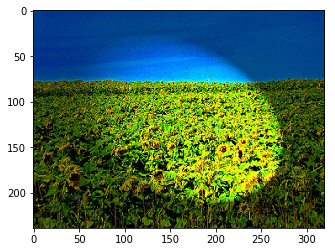

In [52]:
# check a particular test case

%matplotlib inline

import matplotlib.pyplot as plt
from scipy.ndimage import imread
test_img_path = '..\\ClassSampleData\\flower_photos\\sunflowers\\2803725948_5fd1f2fc99_n.jpg'
test_img = imread(test_img_path)
plt.imshow(test_img)


with tf.Session() as sess:
    img = N2_6_utils.load_image(test_img_path)
    img = img.reshape((1, 224, 224, 3))

    feed_dict = {input_: img}
    code = sess.run(vgg.relu6, feed_dict=feed_dict)
        
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: code}
    prediction = sess.run(predicted, feed_dict=feed).squeeze()

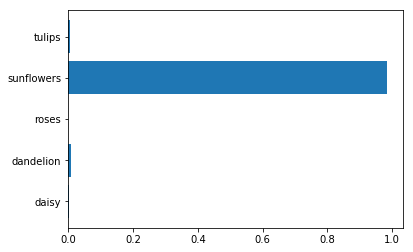

In [53]:
plt.barh(np.arange(5), prediction)
_ = plt.yticks(np.arange(5), lb.classes_)